# Parcial 1 Machine Learning. Binary Classifier.

## Funciones y librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Funciones auxiliares

In [2]:
## Calculo de los IV (Funcion sacada de https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python/notebook)
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    #print('El IV de esta variable es:',iv)
    #print(df[feature].value_counts())
    return iv, data

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

## Preprocesamiento

In [4]:
# Se obtienen los datos de los archivos de texto plano
xtrain = pd.read_csv("datos/xtrain.txt", sep="   ", header=None, engine='python')
ytrain = pd.read_csv("datos/ytrain.txt", sep="   ", header=None, engine='python')
xtest = pd.read_csv("datos/xtest.txt", sep="   ", header=None, engine='python')

In [5]:
# Creo un dataframe donde agrego la etiqueta de cada dato
data_labeled = xtrain.copy()
data_labeled.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",  "N", "O", "P"]
data_labeled["class"] = ytrain
data_labeled.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,class
0,40572.0,725.331,250.71401,206.47193,1.214276,0.567264,40900.0,227.28369,0.767479,0.991980,0.969089,0.906546,0.006179,0.002574,0.821825,0.997923,1.0
1,38180.0,740.017,272.92339,178.76282,1.526735,0.755635,38709.0,220.48194,0.718669,0.986334,0.876118,0.807853,0.007148,0.001878,0.652626,0.996387,0.0
2,46827.0,808.608,300.96747,198.95893,1.512712,0.750329,47295.0,244.17614,0.781766,0.990105,0.899974,0.811304,0.006427,0.001718,0.658214,0.995688,0.0
3,72058.0,1035.943,397.71702,233.41022,1.703940,0.809677,73724.0,302.89783,0.764541,0.977402,0.843763,0.761591,0.005519,0.001145,0.580021,0.988322,1.0
4,80886.0,1136.801,391.65449,263.80113,1.484658,0.739136,82299.0,320.91627,0.719492,0.982831,0.786528,0.819386,0.004842,0.001346,0.671394,0.996790,1.0


In [6]:
xtrain.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",  "N", "O", "P"]
xtrain

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,40572.0,725.331,250.71401,206.47193,1.214276,0.567264,40900.0,227.28369,0.767479,0.991980,0.969089,0.906546,0.006179,0.002574,0.821825,0.997923
1,38180.0,740.017,272.92339,178.76282,1.526735,0.755635,38709.0,220.48194,0.718669,0.986334,0.876118,0.807853,0.007148,0.001878,0.652626,0.996387
2,46827.0,808.608,300.96747,198.95893,1.512712,0.750329,47295.0,244.17614,0.781766,0.990105,0.899974,0.811304,0.006427,0.001718,0.658214,0.995688
3,72058.0,1035.943,397.71702,233.41022,1.703940,0.809677,73724.0,302.89783,0.764541,0.977402,0.843763,0.761591,0.005519,0.001145,0.580021,0.988322
4,80886.0,1136.801,391.65449,263.80113,1.484658,0.739136,82299.0,320.91627,0.719492,0.982831,0.786528,0.819386,0.004842,0.001346,0.671394,0.996790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,60453.0,978.679,404.64330,190.78109,2.120982,0.881877,61185.0,277.43675,0.679858,0.988036,0.793135,0.685633,0.006694,0.000912,0.470092,0.997058
8996,71081.0,1078.031,397.44650,228.98614,1.735679,0.817349,72466.0,300.83740,0.697693,0.980888,0.768601,0.756926,0.005591,0.001132,0.572936,0.994434
8997,38172.0,712.280,255.33277,190.54541,1.340010,0.665651,38486.0,220.45884,0.744094,0.991841,0.945482,0.863418,0.006689,0.002293,0.745490,0.998964
8998,55035.0,917.600,379.34682,185.39058,2.046203,0.872446,55591.0,264.71256,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380


In [7]:
# Normalización de los datos
xtrain_scaled = StandardScaler().fit_transform(xtrain)

# Una vez normalizados, los datos ahora tienen una media de 0 y una varianza de 1.
print(np.round(xtrain_scaled.mean(axis=0),2))
print(xtrain_scaled.std(axis=0)) 

[-0.  0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
label_columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",  "N", "O", "P"]
xtrain_scaled = pd.DataFrame(data = xtrain_scaled, columns=label_columns)
xtrain_scaled

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,-0.549087,-0.774331,-0.962406,-0.070255,-1.463230,-1.857073,-0.555858,-0.597483,0.358653,1.039910,1.672612,1.660181,-0.142966,1.513266,1.717778,0.706296
1,-0.626415,-0.707476,-0.710914,-0.662151,-0.291336,0.018312,-0.625624,-0.708948,-0.595670,-0.088413,0.178521,0.183958,0.714515,0.397008,0.142023,0.380536
2,-0.346878,-0.395233,-0.393351,-0.230741,-0.343930,-0.034516,-0.352227,-0.320655,0.637992,0.665079,0.561909,0.235580,0.076294,0.139880,0.194065,0.232332
3,0.468780,0.639654,0.702210,0.505175,0.373284,0.556346,0.489330,0.641659,0.301216,-1.873210,-0.341433,-0.508012,-0.727173,-0.777375,-0.534150,-1.330429
4,0.754169,1.098786,0.633560,1.154357,-0.449147,-0.145947,0.762377,0.936939,-0.579577,-0.788412,-1.261212,0.356470,-1.326658,-0.455257,0.316805,0.466037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.093618,0.378974,0.780641,-0.405428,1.937428,1.275151,0.090061,0.224410,-1.354485,0.251762,-1.155038,-1.644181,0.311981,-1.150804,-1.557923,0.522806
8996,0.437196,0.831250,0.699147,0.410672,0.492324,0.632719,0.449273,0.607893,-1.005778,-1.176737,-1.549312,-0.577802,-0.663398,-0.798567,-0.600134,-0.033863
8997,-0.626673,-0.833742,-0.910104,-0.410463,-0.991658,-0.877553,-0.632725,-0.709327,-0.098571,1.012084,1.293234,1.015084,0.307988,1.062257,1.006868,0.927258
8998,-0.081533,0.100927,0.494192,-0.520575,1.656965,1.181261,-0.088064,0.015890,0.988534,0.643841,-0.701196,-1.462016,0.488380,-0.997364,-1.401013,0.379030


## Analisis de Descriptores

In [9]:
IVs = {}
i = 1
for col in data_labeled.columns:
    if col != "class":
        iv, data = calc_iv(data_labeled, col, 'class')
        IVs[col] = iv

In [10]:
df = pd.DataFrame([[key, np.round(IVs[key],5)] for key in IVs.keys()], columns=['Feature', 'IV'])
df

,Feature,IV
0,A,0.00323
1,B,0.00031
2,C,0.00000
3,D,0.00000
4,E,0.00000
5,F,0.00000
6,G,0.00411
7,H,0.00323
8,I,0.00000
9,J,0.00000


In [11]:
xtrain_scaled

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,-0.549087,-0.774331,-0.962406,-0.070255,-1.463230,-1.857073,-0.555858,-0.597483,0.358653,1.039910,1.672612,1.660181,-0.142966,1.513266,1.717778,0.706296
1,-0.626415,-0.707476,-0.710914,-0.662151,-0.291336,0.018312,-0.625624,-0.708948,-0.595670,-0.088413,0.178521,0.183958,0.714515,0.397008,0.142023,0.380536
2,-0.346878,-0.395233,-0.393351,-0.230741,-0.343930,-0.034516,-0.352227,-0.320655,0.637992,0.665079,0.561909,0.235580,0.076294,0.139880,0.194065,0.232332
3,0.468780,0.639654,0.702210,0.505175,0.373284,0.556346,0.489330,0.641659,0.301216,-1.873210,-0.341433,-0.508012,-0.727173,-0.777375,-0.534150,-1.330429
4,0.754169,1.098786,0.633560,1.154357,-0.449147,-0.145947,0.762377,0.936939,-0.579577,-0.788412,-1.261212,0.356470,-1.326658,-0.455257,0.316805,0.466037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.093618,0.378974,0.780641,-0.405428,1.937428,1.275151,0.090061,0.224410,-1.354485,0.251762,-1.155038,-1.644181,0.311981,-1.150804,-1.557923,0.522806
8996,0.437196,0.831250,0.699147,0.410672,0.492324,0.632719,0.449273,0.607893,-1.005778,-1.176737,-1.549312,-0.577802,-0.663398,-0.798567,-0.600134,-0.033863
8997,-0.626673,-0.833742,-0.910104,-0.410463,-0.991658,-0.877553,-0.632725,-0.709327,-0.098571,1.012084,1.293234,1.015084,0.307988,1.062257,1.006868,0.927258
8998,-0.081533,0.100927,0.494192,-0.520575,1.656965,1.181261,-0.088064,0.015890,0.988534,0.643841,-0.701196,-1.462016,0.488380,-0.997364,-1.401013,0.379030


In [12]:
xtrain_scaled = xtrain_scaled.drop(['C','D','E','F','I','J','K','L','M','N','O','P'], axis=1)

In [13]:
# Separación de los datos en datos de entramiento y prueba
X_train, X_test, y_train, y_test = train_test_split(xtrain_scaled, ytrain, test_size=0.3, random_state=0)
#X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.1, random_state=31)

In [14]:
y_test.shape # Verifico la dimensión de mis datos

(2700, 1)

## Selección de Modelo

### Regresión Logistica

Precisión 0.81407
      0     1
0  1180   160
1   342  1018


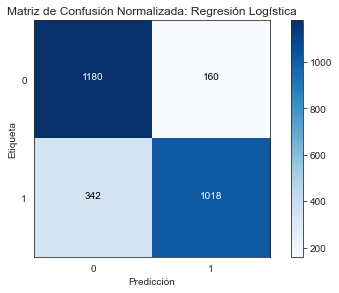

In [15]:
model = LogisticRegression(C=1,
                           solver='newton-cg')
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')

### Grid Search

In [16]:
c_range =  np.arange(0.1, 1.1, 0.1)
solver_list = ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')
param_grid = {'C': c_range, 'solver': solver_list}

In [17]:
clasificadorLR = LogisticRegression()
modeloLR = GridSearchCV(clasificadorLR, param_grid)
modeloLR.fit(X_train,y_train) 
print("Mejor parámetro: {}".format(modeloLR.best_params_)) 
print("Mejor cross-validation score: {:.2f}".format(modeloLR.best_score_))

Mejor parámetro: {'C': 1.0, 'solver': 'newton-cg'}
Mejor cross-validation score: 0.82


### Redes Neuronales

Precisión 0.9137
Sensibilidad 0.88382
      0     1
0  1265    75
1   158  1202


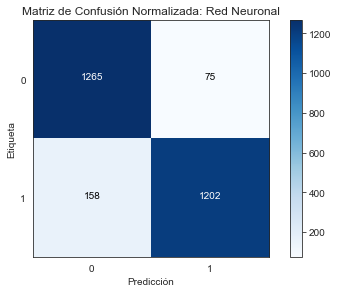

In [18]:
model = MLPClassifier( hidden_layer_sizes=(10, 5), activation='tanh', solver='adam') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit( X_train, y_train ) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict( X_test ) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(f'Sensibilidad {round(recall_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')



In [19]:
hiden_layer =  [(1,), (2,2), (6, 4), (10,5), (10,10), (50,50)]
activation_list = ['identity', 'logistic', 'tanh', 'relu']
solver_list = ['lbfgs', 'sgd', 'adam']
param_grid = {'hidden_layer_sizes': hiden_layer, 'activation': activation_list, 'solver': solver_list}

In [20]:
calsificadorMLP = MLPClassifier()
modeloMLP = GridSearchCV(calsificadorMLP, param_grid)
modeloMLP.fit(X_train,y_train) 
print("Mejor parámetro: {}".format(modeloMLP.best_params_)) 
print("Mejor cross-validation score: {:.2f}".format(modeloMLP.best_score_))

Mejor parámetro: {'activation': 'tanh', 'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs'}
Mejor cross-validation score: 0.94
